In [1]:
from matplotlib.pyplot import imshow


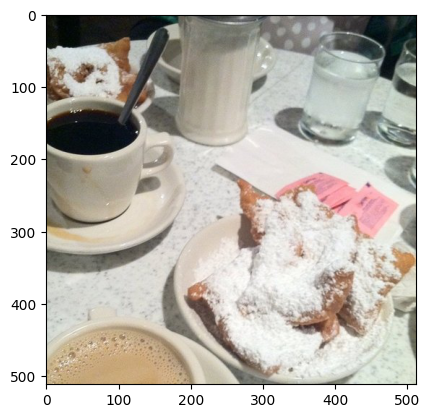

In [2]:
import numpy
from PIL import Image
from urllib.request import urlopen

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))


img_npy = numpy.asarray(img.convert('RGB'))
img.size, img_npy.shape
%matplotlib inline
imshow(img)

/home/dnth/mambaforge-pypy3/envs/pt-to-onnx-tensorrt/lib/python3.11/site-packages/onnxruntime_extensions/pnp/_onnx_ops.py:73: UserWarning: The maximum opset needed by this model is only 9.
  warnings.warn('The maximum opset needed by this model is only %d.' % op_version)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1050603..2.5920699].


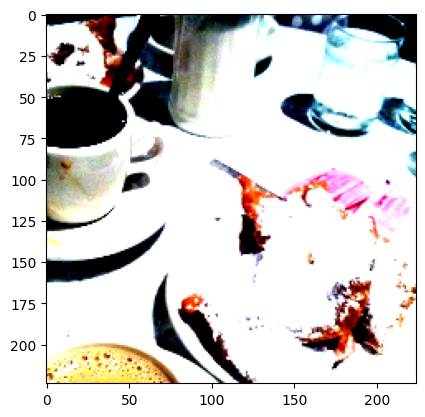

In [3]:
from onnxruntime_extensions import pnp
pre = pnp.PreMobileNet(size=224)
img2 = pre.forward(img_npy)
%matplotlib inline
imshow(img2.squeeze(0).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5528543].


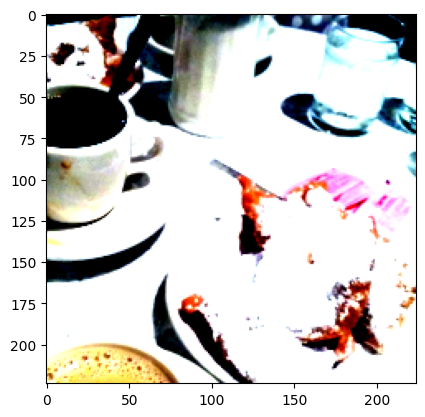

In [4]:
from torchvision import transforms as T
pre_torch=T.Compose([
   T.Resize(256),
   T.CenterCrop(224),
   T.ToTensor(),
   T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
   )
])

img3 = pre_torch(img.convert('RGB'))
%matplotlib inline
imshow(img3.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


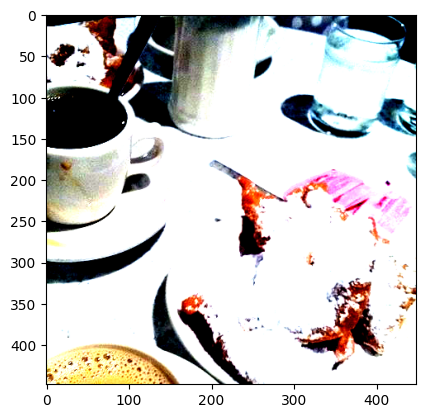

In [5]:
from onnxruntime_extensions import pnp
pre = pnp.ImageNetPreProcessing(size=448, resize_image=False)
img2 = pre.forward(img_npy)
%matplotlib inline
imshow(img2.squeeze(0).permute(1, 2, 0))

In [6]:
import onnx
model = onnx.load("eva02_large_patch14_448.onnx")
# full_model = pnp.SequentialProcessingModule(pnp.ImageNetPreProcessing(size=448, resize_image=False), model, pnp.ImageNetPostProcessing())
full_model = pnp.SequentialProcessingModule(pnp.ImageNetPreProcessing(size=448, resize_image=False), model)

In [7]:
import torch
ids, probabilities = full_model.forward(torch.from_numpy(img_npy))

/tmp/ipykernel_30441/3485058425.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  ids, probabilities = full_model.forward(torch.from_numpy(img_npy))
2024-09-12 12:33:51.645732092 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 24 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2024-09-12 12:33:51.657784341 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred exe

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
ids

In [ ]:
probabilities

In [ ]:
from imagenet_classes import IMAGENET2012_CLASSES

im_classes = list(IMAGENET2012_CLASSES.values())
class_names = [im_classes[i] for i in ids[0]]

# Print class names and probabilities
for name, prob in zip(class_names, probabilities[0]):
    print(f"{name}: {prob:.2f}%")

In [8]:
pnp.export(full_model, torch.from_numpy(img_npy), opset_version=20, output_path="eva02_large_patch14_448_pre.onnx")

/home/dnth/mambaforge-pypy3/envs/pt-to-onnx-tensorrt/lib/python3.11/site-packages/onnxruntime_extensions/pnp/_imagenet.py:24: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert img.shape[-1] == 3, 'the input image should be in RGB channels'
/home/dnth/mambaforge-pypy3/envs/pt-to-onnx-tensorrt/lib/python3.11/site-packages/onnxruntime_extensions/pnp/_imagenet.py:47: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x -= torch.reshape(torch.tensor(mean), (3, 1, 1))
/home/dnth/mambaforge-pypy3/envs/pt-to-onnx-tensorrt/li

In [ ]:
import onnxruntime as ort
import numpy as np
from PIL import Image

session = ort.InferenceSession("eva02_large_patch14_448_prepost.onnx", providers=["CUDAExecutionProvider"])

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

image = Image.open('beignets-task-guide.png')
img_npy = np.array(image)
img_uint8 = img_npy.astype(np.uint8)
img_uint8.shape

In [ ]:
img_uint8.shape

In [ ]:
output = session.run([output_name], {input_name: img_uint8})[0]

In [ ]:
output[0]
